In [1]:
import tensorflow as tf
print(tf.__version__)

2.14.0


# Validation, regularisation and callbacks

 ## Coding tutorials
 #### [1. Validation sets](#coding_tutorial_1)
 #### [2. Model regularisation](#coding_tutorial_2)
 #### [3. Introduction to callbacks](#coding_tutorial_3)
 #### [4. Early stopping / patience](#coding_tutorial_4)

***
<a id="coding_tutorial_1"></a>
## Validation sets

#### Load the data

In [2]:
# Load the diabetes dataset
from sklearn.datasets import load_diabetes

diabetes_dataset = load_diabetes()
print(diabetes_dataset["DESCR"])

.. _diabetes_dataset:

Diabetes dataset
----------------

Ten baseline variables, age, sex, body mass index, average blood
pressure, and six blood serum measurements were obtained for each of n =
442 diabetes patients, as well as the response of interest, a
quantitative measure of disease progression one year after baseline.

**Data Set Characteristics:**

  :Number of Instances: 442

  :Number of Attributes: First 10 columns are numeric predictive values

  :Target: Column 11 is a quantitative measure of disease progression one year after baseline

  :Attribute Information:
      - age     age in years
      - sex
      - bmi     body mass index
      - bp      average blood pressure
      - s1      tc, total serum cholesterol
      - s2      ldl, low-density lipoproteins
      - s3      hdl, high-density lipoproteins
      - s4      tch, total cholesterol / HDL
      - s5      ltg, possibly log of serum triglycerides level
      - s6      glu, blood sugar level

Note: Each of these 1

In [3]:
# Save the input and target variables

data = diabetes_dataset['data']
targets = diabetes_dataset['target']


In [4]:
# Normalise the target data (this will make clearer training curves)
targets = (targets - targets.mean(axis = 0)) / targets.std()


In [5]:
# Split the data into train and test sets
from sklearn.model_selection import train_test_split

train_data, test_data, train_targets, test_targets = train_test_split(data, targets, test_size=0.1)


#### Train a feedforward neural network model

In [6]:
# Build the model

def get_model():
  model = tf.keras.models.Sequential([
      tf.keras.layers.Dense(128, activation='relu', input_shape=(train_data.shape[1],)),
      tf.keras.layers.Dense(128, activation='relu'),
      tf.keras.layers.Dense(128, activation='relu'),
      tf.keras.layers.Dense(128, activation='relu'),
      tf.keras.layers.Dense(128, activation='relu'),
      tf.keras.layers.Dense(128, activation='relu'),
      tf.keras.layers.Dense(1)
  ])
  return model

model = get_model()

In [7]:
# Print the model summary
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               1408      
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 dense_2 (Dense)             (None, 128)               16512     
                                                                 
 dense_3 (Dense)             (None, 128)               16512     
                                                                 
 dense_4 (Dense)             (None, 128)               16512     
                                                                 
 dense_5 (Dense)             (None, 128)               16512     
                                                                 
 dense_6 (Dense)             (None, 1)                 1

In [8]:
# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])


In [9]:
# Train the model, with some of the data reserved for validation
history = model.fit(train_data, train_targets, epochs=100,
                    validation_split=0.15, batch_size=64, verbose=False)

In [10]:
# Evaluate the model on the test set
model.evaluate(test_data, test_targets, verbose=2)


2/2 - 0s - loss: 0.9777 - mae: 0.7262 - 25ms/epoch - 13ms/step


[0.9777495265007019, 0.7261527180671692]

#### Plot the learning curves

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline

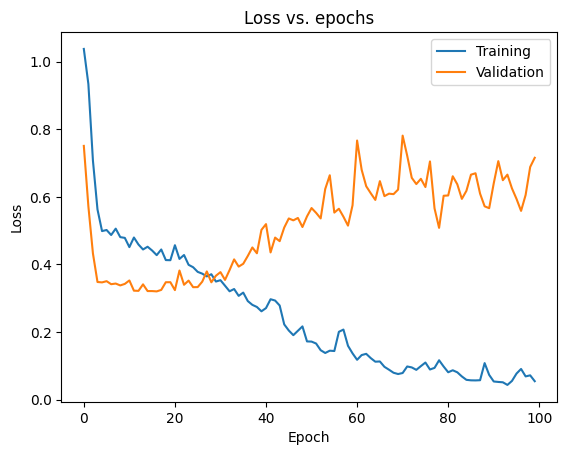

In [12]:
# Plot the training and validation loss

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

***
<a id="coding_tutorial_2"></a>
## Model regularisation

#### Adding regularisation with weight decay and dropout

In [13]:
from tensorflow.keras.layers import Dropout
from tensorflow.keras import regularizers

In [14]:
def get_regularised_model(wd, rate):
    model = tf.keras.models.Sequential([
        tf.keras.layers.Dense(128, kernel_regularizer=regularizers.l2(wd), activation="relu", input_shape=(train_data.shape[1],)),
        Dropout(rate),
        tf.keras.layers.Dense(128, kernel_regularizer=regularizers.l2(wd), activation="relu"),
        Dropout(rate),
        tf.keras.layers.Dense(128, kernel_regularizer=regularizers.l2(wd), activation="relu"),
        Dropout(rate),
        tf.keras.layers.Dense(128, kernel_regularizer=regularizers.l2(wd), activation="relu"),
        Dropout(rate),
        tf.keras.layers.Dense(128, kernel_regularizer=regularizers.l2(wd), activation="relu"),
        Dropout(rate),
        tf.keras.layers.Dense(128, kernel_regularizer=regularizers.l2(wd), activation="relu"),
        Dropout(rate),
        tf.keras.layers.Dense(1)
    ])
    return model

In [15]:
# Re-build the model with weight decay and dropout layers
model = get_regularised_model(1e-5, 0.3)


In [16]:
# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])


In [17]:
# Train the model, with some of the data reserved for validation
history = model.fit(train_data, train_targets, epochs=100,
                    validation_split=0.15, batch_size=64, verbose=False)


In [18]:
# Evaluate the model on the test set
model.evaluate(test_data, test_targets, verbose=2)


2/2 - 0s - loss: 0.5955 - mae: 0.5909 - 26ms/epoch - 13ms/step


[0.5954614281654358, 0.5908777713775635]

#### Plot the learning curves

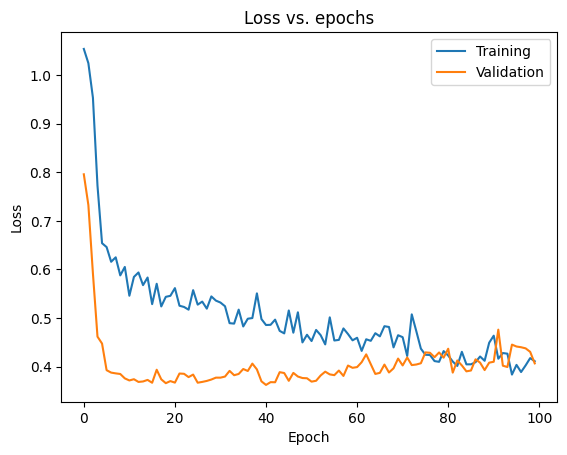

In [19]:
# Plot the training and validation loss

import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

***
<a id="coding_tutorial_3"></a>
## Introduction to callbacks

#### Example training callback

In [20]:
# Write a custom callback

from tensorflow.keras.callbacks import Callback

class PredictionCallBack(Callback):

  def on_predict_begin(self, logs=None):
    print("Starting prediction...")

  def on_predict_batch_begin(self, batch, logs=None):
    print(f'Prediction: Starting batch {batch}')

  def on_predict_batch_end(self, batch, logs=None):
    print(f'Prediction: Finished batch {batch}')

  def on_predict_end(self, logs=None):
    print(f'Finished predicting:')


In [21]:
# Re-build the model
model = get_regularised_model(1e-5, 0.3)


In [22]:
# Compile the model
model.compile(optimizer='adam', loss='mse')


#### Train the model with the callback

In [23]:
# Train the model, with some of the data reserved for validation
model.fit(train_data, train_targets, epochs=3,
          batch_size=128, verbose=False, callbacks=[PredictionCallBack()])


In [24]:
# Evaluate the model
model.evaluate(test_data, test_targets, verbose=False, callbacks=[PredictionCallBack()])


0.7956128716468811

In [25]:
# Make predictions with the model
model.predict(test_data, verbose=False, callbacks=[PredictionCallBack()])


Starting prediction...
Prediction: Starting batch 0
Prediction: Finished batch 0
Prediction: Starting batch 1
Prediction: Finished batch 1
Finished predicting:


array([[-0.09020228],
       [-0.0878168 ],
       [ 0.01325824],
       [ 0.04687054],
       [-0.0607308 ],
       [-0.12805581],
       [ 0.03379594],
       [ 0.00236701],
       [-0.03157529],
       [-0.09020649],
       [-0.12534305],
       [-0.03103764],
       [-0.00693338],
       [ 0.00263634],
       [-0.01492599],
       [-0.11902437],
       [-0.10910147],
       [-0.07265197],
       [-0.08732697],
       [-0.07697259],
       [-0.04710942],
       [ 0.02964032],
       [-0.03392833],
       [ 0.04380323],
       [ 0.02711457],
       [-0.06611555],
       [ 0.00102446],
       [ 0.0028273 ],
       [ 0.00986099],
       [-0.00941354],
       [-0.07791664],
       [ 0.00330218],
       [-0.07194783],
       [-0.07518782],
       [-0.04366545],
       [-0.10466377],
       [-0.12966353],
       [ 0.01422856],
       [ 0.02667275],
       [-0.11161427],
       [-0.04497704],
       [-0.05619873],
       [-0.08013885],
       [-0.0085432 ],
       [-0.0151995 ]], dtype=flo

***
<a id="coding_tutorial_4"></a>
## Early stopping / patience

#### Re-train the models with early stopping

In [26]:
# Re-train the unregularised model
unregularised_model = get_model()
unregularised_model.compile(optimizer='adam', loss='mae')
unreg_history = unregularised_model.fit(train_data, train_targets, epochs=100, validation_split=0.15,
                                        batch_size=64, verbose=False, callbacks=[tf.keras.callbacks.EarlyStopping()])


In [27]:
# Evaluate the model on the test set
unregularised_model.evaluate(test_data, test_targets, verbose=2)


2/2 - 0s - loss: 0.6336 - 43ms/epoch - 21ms/step


0.6335543394088745

In [28]:
# Re-train the regularised model
regularised_model = get_regularised_model(1e-8, 0.2)
regularised_model.compile(optimizer='adam', loss='mae')
reg_history = regularised_model.fit(train_data, train_targets, epochs=100, validation_split=0.15,
                                        batch_size=64, verbose=False, callbacks=[tf.keras.callbacks.EarlyStopping()])


In [29]:
# Evaluate the model on the test set
regularised_model.evaluate(test_data, test_targets, verbose=2)


2/2 - 0s - loss: 0.6108 - 29ms/epoch - 14ms/step


0.6108350157737732

#### Plot the learning curves

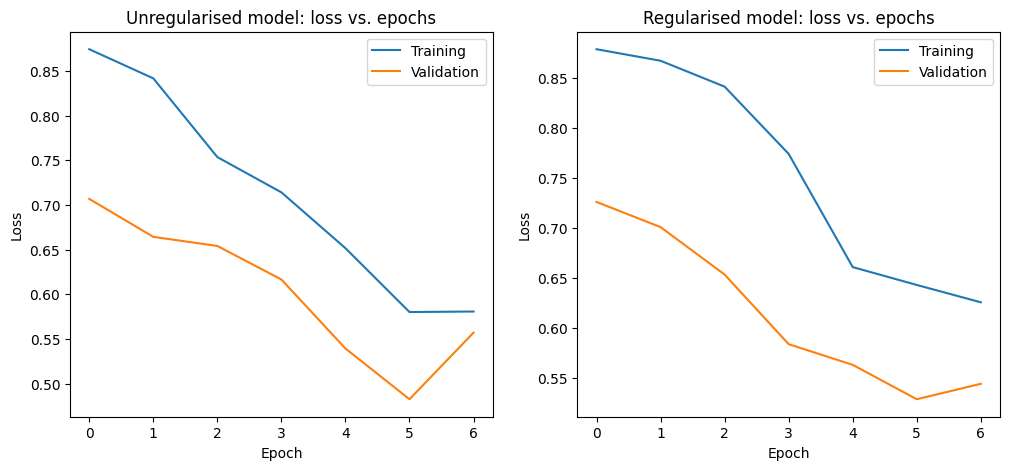

In [30]:
# Plot the training and validation loss

import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12, 5))

fig.add_subplot(121)

plt.plot(unreg_history.history['loss'])
plt.plot(unreg_history.history['val_loss'])
plt.title('Unregularised model: loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')

fig.add_subplot(122)

plt.plot(reg_history.history['loss'])
plt.plot(reg_history.history['val_loss'])
plt.title('Regularised model: loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')

plt.show()